# **Introducción a las Series de Tiempo**

## **Librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
from datetime import datetime

In [52]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## **Datos**

In [3]:
df = pd.read_csv('./Data/AirPassengers.csv')

In [4]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

## **Trabajando con Series de Tiempo**

### Ajustamos el formato de los datos

In [6]:
df['Month'] = pd.to_datetime(df['Month'])

### Ajustamos el indice de nuestro dataset

In [7]:
df.set_index('Month', inplace=True)

In [9]:
df.sample()

#Passengers
Month                  
1952-05-01          183

### Convertimos nuestro dataframe en una serie de tiempo

In [10]:
ts = df['#Passengers']

In [11]:
# Consultando por el indice
ts['1949-01-01']

112

In [12]:
# Consultar utilizando la libreria datetime
ts[datetime(1949,1,1)]

112

In [13]:
# Consultar un rango de fechas
ts['1949-01-01':'1949-12-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [14]:
# Traer un rango hasta una fecha concreta
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [15]:
# Traer todos los datos de un año
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

## **Estacionariedad**

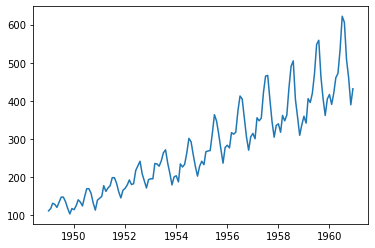

In [17]:
plt.plot(ts)
plt.show()

### **Media y desviación estandar movil**

In [19]:
def rolling_MS(timeseries):
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12, center=True).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label ='Media Movil')
    plt.plot(rolstd, color='green', label="Std Movil")
    plt.legend(loc='best')
    plt.title('Media Movil y Std Movil')

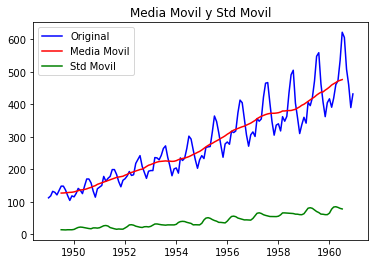

In [20]:
rolling_MS(ts)

### **El test de Dickey-Fuller**

In [21]:
wf = pd.DataFrame(columns=['c'])

def test_DF(timeseries):
    models = ['c', 'ct', 'ctt', 'nc']
    for i in range(len(models)):
        dftest = adfuller(timeseries, autolag='AIC', regression=models[i])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                                 'p-value',
                                                 '# Lags',
                                                 'Number of Observations'])
        for key, value in dftest[4].items():
            dfoutput['Critical value (%s)'%key] = value
        wf[models[i]] = dfoutput

In [22]:
test_DF(ts)

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [23]:
wf

c          ct         ctt          nc
Test Statistic            0.815369   -2.100782   -3.233678    2.390602
p-value                   0.991880    0.545659    0.195942    0.997180
# Lags                   13.000000   13.000000   13.000000   13.000000
Number of Observations  130.000000  130.000000  130.000000  130.000000
Critical value (1%)      -3.481682   -4.030152   -4.462542   -2.583153
Critical value (5%)      -2.884042   -3.444818   -3.878611   -1.943251
Critical value (10%)     -2.578770   -3.147182   -3.581753   -1.614926

**Nuestra serie NO es estacionaria !!!**

## **Hacer la serie estacionaria**

### **Tendencia**

#### Suavizamos nuestra serie

In [24]:
ts_log = np.log(ts)

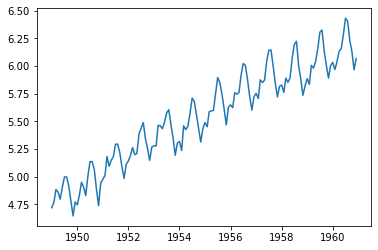

In [25]:
plt.plot(ts_log)
plt.show()

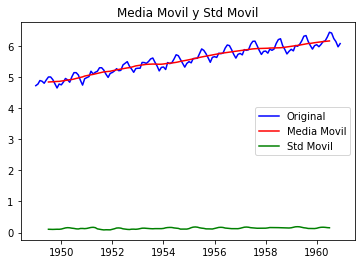

In [26]:
rolling_MS(ts_log)

In [27]:
moving_avg = ts_log.rolling(12, center=True).mean()

#### Quitamos la media de nuestros datos

In [28]:
ts_diff_mean = ts_log - moving_avg

In [29]:
ts_diff_mean.dropna(inplace=True)

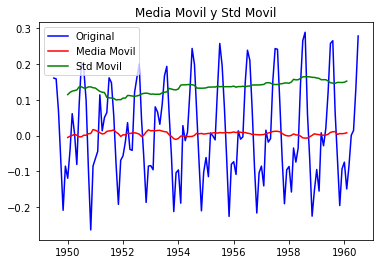

In [30]:
rolling_MS(ts_diff_mean)

In [31]:
test_DF(ts_diff_mean)

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [32]:
wf

c          ct         ctt          nc
Test Statistic           -4.492454   -4.519067   -4.478075   -2.946760
p-value                   0.000203    0.001405    0.007024    0.003158
# Lags                   13.000000   13.000000   13.000000   13.000000
Number of Observations  119.000000  119.000000  119.000000  119.000000
Critical value (1%)      -3.486535   -4.036934   -4.471237   -2.584784
Critical value (5%)      -2.886151   -3.448049   -3.882970   -1.943476
Critical value (10%)     -2.579896   -3.149068   -3.584424   -1.614765

**Nuestra serie es estacionaria !!!**

### **Estacionalidad (con Tendencia)**

#### Primera diferencia

In [33]:
ts_log_diff = ts_log - ts_log.shift()

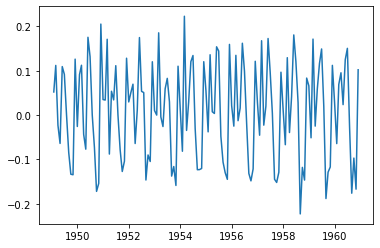

In [34]:
plt.plot(ts_log_diff)
plt.show()

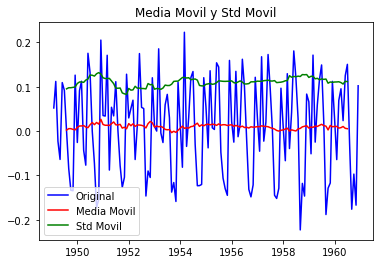

In [35]:
rolling_MS(ts_log_diff)

In [36]:
ts_log_diff.dropna(inplace=True)

In [37]:
test_DF(ts_diff_mean)

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [38]:
wf

c          ct         ctt          nc
Test Statistic           -4.492454   -4.519067   -4.478075   -2.946760
p-value                   0.000203    0.001405    0.007024    0.003158
# Lags                   13.000000   13.000000   13.000000   13.000000
Number of Observations  119.000000  119.000000  119.000000  119.000000
Critical value (1%)      -3.486535   -4.036934   -4.471237   -2.584784
Critical value (5%)      -2.886151   -3.448049   -3.882970   -1.943476
Critical value (10%)     -2.579896   -3.149068   -3.584424   -1.614765

<strong> Nuestra serie es estacionaria !!! </strong>

#### **Descomposición**

In [40]:
decomposition = seasonal_decompose(ts_log)

In [41]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

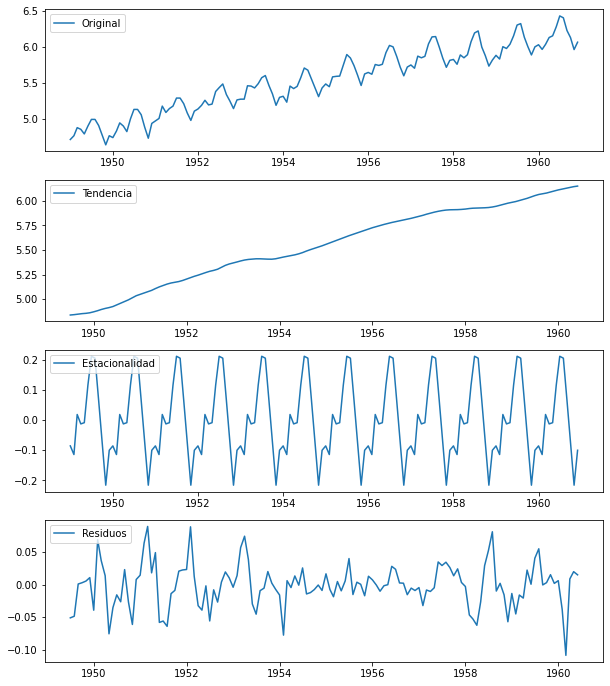

In [43]:
plt.figure(figsize=(10,12))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc=2)
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc=2)
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc=2)
plt.subplot(414)
plt.plot(residual, label='Residuos')
plt.legend(loc=2)

plt.show()

In [44]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

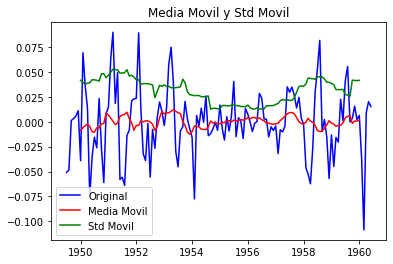

In [45]:
rolling_MS(ts_log_decompose)

In [46]:
test_DF(ts_log_decompose)

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [47]:
wf

c            ct         ctt            nc
Test Statistic         -6.332387e+00 -6.315992e+00   -6.398489 -6.358925e+00
p-value                 2.885059e-08  4.649523e-07    0.000002  1.583763e-09
# Lags                  9.000000e+00  9.000000e+00    9.000000  9.000000e+00
Number of Observations  1.220000e+02  1.220000e+02  122.000000  1.220000e+02
Critical value (1%)    -3.485122e+00 -4.034960e+00   -4.468706 -2.584310e+00
Critical value (5%)    -2.885538e+00 -3.447109e+00   -3.881702 -1.943411e+00
Critical value (10%)   -2.579569e+00 -3.148519e+00   -3.583647 -1.614811e+00

**Nuestra serie es estacionaria !!!**

## **Pronostico de una Serie de Tiempo**

### Identificar los grados de p y q

In [50]:
lag_acf = acf(ts_log_diff, nlags=20, fft=True)
lag_pacf = pacf(ts_log_diff, nlags=20, method='OLS')

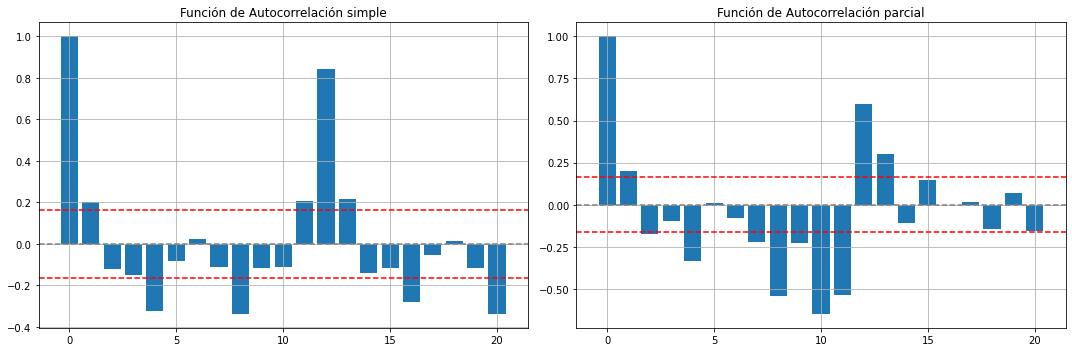

In [51]:
plt.figure(figsize=(15,5))

## ACF
plt.subplot(121)
plt.bar(range(len(lag_acf)),lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.title('Función de Autocorrelación simple')
plt.grid()

## PACF 
plt.subplot(122)
plt.bar(range(len(lag_pacf)), lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.title('Función de Autocorrelación parcial')
plt.grid()

plt.tight_layout()

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


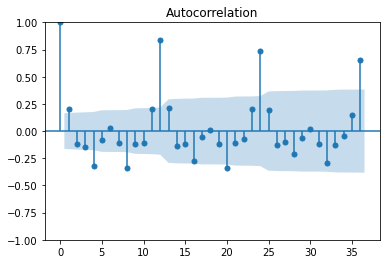

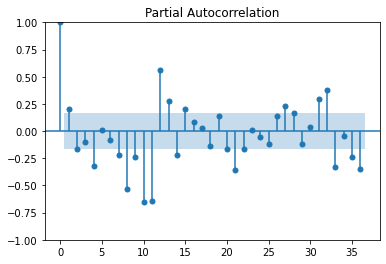

In [53]:
acf = plot_acf(ts_log_diff, lags=36)
pacf = plot_pacf(ts_log_diff, lags=36)

### Contrucción del Modelo AR

In [54]:
model = ARIMA(ts_log, order=(2,1,0))

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
